In [1]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [2]:
import datetime
import json
import os
import pickle
import pprint
import time
import warnings

import joblib
import kaplanmeier as km
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from azureml.core import Dataset, Workspace
from lifelines.statistics import logrank_test
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    ParameterGrid,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sksurv.ensemble import RandomSurvivalForest
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from uc2_functions import *
from tqdm import tqdm

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Goal

The goal is to train the best model that was validated internally to 100% of the internal dataset, to create a final model for external valiation.
Page 116 https://www.ncbi.nlm.nih.gov/books/NBK543527/pdf/Bookshelf_NBK543527.pdf

# Parameters

In [5]:
RANDOM_STATE = 42
PARENT_RUN_ID = None
EXPERIMENT_NAME = "UC2_final"
DIR_MODEL_PKL = "../models_pkl"  # Weights for the models used during inference
DIR_ARTIFACTS = "artifacts"
PATH_IMPORTANCES = "../04_survival_models/src/experiments/df_importances.json"
S = 100
DIR_SC = os.path.join(os.path.dirname(os.getcwd()), "sc")
PATH_EXTERNAL = "External_Validation_of_AI_model_Florence_MAP.xlsx"
PATH_EXTERNAL_INTEGRATION = "External validation Florence - Missing variables.xlsx"

# Functions

In [6]:
class CollinearitySelector:
    """
    A class to select features based on collinearity, prioritizing internal feature importance
    and external dataset availability.
    """
    
    def __init__(self, 
                 df: pd.DataFrame, 
                 features_internal: list, 
                 features_external: list, 
                 method: str = "spearman", 
                 threshold: float = 0.6, 
                 top_x: int = 16, 
                 verbose: bool = False):
        """
        Initializes the CollinearitySelector with necessary parameters.
        
        Parameters:
        - df (pd.DataFrame): DataFrame containing feature data.
        - features_internal (list): List of internal features ordered by importance (most important first).
        - features_external (list): List of features available in the external dataset.
        - method (str): Correlation method ('spearman', 'pearson', etc.).
        - threshold (float): Correlation threshold to consider features as highly correlated.
        - top_x (int): Number of top features to return after filtering.
        - verbose (bool): If True, prints detailed information during processing.
        """
        self.df = df
        self.features_internal = features_internal
        self.features_external = features_external
        self.method = method
        self.threshold = threshold
        self.top_x = top_x
        self.verbose = verbose
        self.corr_matrix = None
        self.highly_correlated_pairs = []
        self.features_to_drop = set()
        self.filtered_features = []
        
        if self.verbose:
            print("Initialized CollinearitySelector with the following parameters:")
            print(f" - Correlation method: {self.method}")
            print(f" - Threshold: {self.threshold}")
            print(f" - Top X features to retain: {self.top_x}")
            print(f" - Verbose mode: {self.verbose}\n")
    
    def _compute_correlation_matrix(self):
        """Computes the absolute correlation matrix using the specified method."""
        if self.verbose:
            print("Computing correlation matrix...")
        self.corr_matrix = self.df.corr(method=self.method).abs()
        if self.verbose:
            print("Correlation matrix computed.\n")
    
    def _get_highly_correlated_pairs(self):
        """Identifies pairs of features with correlation above the threshold."""
        if self.verbose:
            print(f"Identifying feature pairs with correlation above {self.threshold}...")
        # Select upper triangle of the correlation matrix to avoid duplicate pairs and self-correlations
        upper_tri = self.corr_matrix.where(np.triu(np.ones(self.corr_matrix.shape), k=1).astype(bool))
        # Find index pairs with correlation above the threshold
        self.highly_correlated_pairs = [
            (feature1, feature2, self.corr_matrix.loc[feature1, feature2])
            for feature1 in upper_tri.index
            for feature2 in upper_tri.columns
            if upper_tri.loc[feature1, feature2] > self.threshold
        ]
        if self.verbose:
            print(f"Found {len(self.highly_correlated_pairs)} highly correlated pairs.\n")
    
    def _filter_features(self):
        """
        Determines which features to drop based on correlated pairs.

        Rules:
        1. If both features are in features_external, keep the one with higher importance.
        2. If only one feature is in features_external, keep the one in features_external.
        3. If neither feature is in features_external, drop both.
        """
        if self.verbose:
            print("Filtering features based on correlated pairs...")

        for feature1, feature2, corr in self.highly_correlated_pairs:
            in_external_1 = feature1 in self.features_external
            in_external_2 = feature2 in self.features_external

            if in_external_1 and in_external_2:
                # Both features are in external; keep the one with higher importance
                idx1 = self.features_internal.index(feature1) if feature1 in self.features_internal else float('inf')
                idx2 = self.features_internal.index(feature2) if feature2 in self.features_internal else float('inf')
                if idx1 > idx2:
                    self.features_to_drop.add(feature1)
                    if self.verbose:
                        print(f"Dropping '{feature1}' in favor of '{feature2}' based on internal importance.")
                else:
                    self.features_to_drop.add(feature2)
                    if self.verbose:
                        print(f"Dropping '{feature2}' in favor of '{feature1}' based on internal importance.")
            elif in_external_1 and not in_external_2:
                # Keep feature1, drop feature2
                self.features_to_drop.add(feature2)
                if self.verbose:
                    print(f"Dropping '{feature2}' since it's not present in the external dataset.")
            elif in_external_2 and not in_external_1:
                # Keep feature2, drop feature1
                self.features_to_drop.add(feature1)
                if self.verbose:
                    print(f"Dropping '{feature1}' since it's not present in the external dataset.")
            else:
                # Neither feature is in external; drop both
                self.features_to_drop.update([feature1, feature2])
                if self.verbose:
                    print(f"Dropping both '{feature1}' and '{feature2}' as neither is present in the external dataset.")

        if self.verbose:
            print("\nFeature dropping summary:")
            for feature in self.features_to_drop:
                print(f" - {feature}")
            print()

        # Final filtered features: exclude the ones marked to drop and preserve the order based on features_internal
        self.filtered_features = [feature for feature in self.features_internal if feature not in self.features_to_drop]

        # If top_x is specified, return only the top_x features
        if self.top_x and len(self.filtered_features) > self.top_x:
            if self.verbose:
                print(f"Limiting to top {self.top_x} features based on internal importance.")
            self.filtered_features = self.filtered_features[:self.top_x]

        # Ensure the final list includes only features present in features_external
        self.filtered_features = [feature for feature in self.filtered_features if feature in self.features_external]

        if self.verbose:
            print(f"\nTotal features after filtering: {len(self.filtered_features)}\n")
    
    def select_features(self):
        """
        Executes the feature selection process and returns the filtered features.
        
        Returns:
        - filtered_features (list): List of filtered features based on collinearity and priority rules.
        """
        self._compute_correlation_matrix()
        self._get_highly_correlated_pairs()
        self._filter_features()
        return self.filtered_features

def tune_sksurv_model_fixed_k(model, param_grid, X_tune, y_tune, random_state: int, n_folds=10):
    """Tune sksurv models with feature selection, hyperparameter tuning, stratification based on the 'event', and return the best model"""
    # Initialize variables to track the best model and its performance
    best_score = -1
    best_model = None

    # Stratified K-Fold Cross-Validation based on 'event' indicator
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for train_index, val_index in skf.split(X_tune, y_tune["event"]):
        # Splitting the data into training and validation sets based on the indices
        X_train, X_val = X_tune.iloc[train_index], X_tune.iloc[val_index]
        y_train, y_val = y_tune[train_index], y_tune[val_index]

        # Initialize GridSearchCV without CV strategy since we are manually splitting the folds
        grid_search = GridSearchCV(model, param_grid, n_jobs=-1)

        # Fit the model on the current training fold
        grid_search.fit(X_train, y_train)

        # Evaluate the model on the validation set
        best_model_fold = grid_search.best_estimator_
        predicted_risk = best_model_fold.predict(X_val)
        result_censored = concordance_index_censored(
            y_val["event"], y_val["time"], predicted_risk
        )
        score = result_censored[0]

        # Update the best model if the current one is better
        if score > best_score:
            best_score = score
            best_model = best_model_fold

    # Before returning, fit the best_model (pipeline) to the entire tuning dataset
    if best_model is not None:
        best_model.fit(X_tune, y_tune)
    
    # Return the best model based on the highest concordance index
    return best_model, best_score

def plot_correlation_heatmap(df, method='pearson', threshold=0.5):
    """
    Plots a correlation heatmap for features in the DataFrame that have
    at least one correlation coefficient above the specified threshold.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing numerical features.
    
    method : str, optional (default='pearson')
        The method to use for calculating correlations. 
        Options include 'pearson', 'spearman', and 'kendall'.
    
    threshold : float, optional (default=0.5)
        The minimum absolute correlation coefficient required to include a feature
        in the heatmap. Features with any correlation above this threshold
        (excluding self-correlation) will be included.

    Returns:
    --------
    None
        Displays the correlation heatmap plot.
    """
    
    # Validate the correlation method
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Invalid correlation method. Choose from 'pearson', 'spearman', or 'kendall'.")
    
    # Compute the correlation matrix using the specified method
    corr_matrix = df.corr(method=method)
    
    # Identify columns to keep: those with at least one correlation above the threshold
    # (excluding self-correlation)
    to_keep = [col for col in corr_matrix.columns if (corr_matrix[col].abs().drop(labels=col) >= threshold).any()]
    
    # Check if any features meet the threshold criteria
    if not to_keep:
        print(f"No features found with correlation above the threshold of {threshold}.")
        return
    
    # Subset the correlation matrix to include only the selected features
    selected_corr = corr_matrix.loc[to_keep, to_keep]
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(selected_corr, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Create the heatmap
    sns.heatmap(
        selected_corr,
        mask=mask,                            # Apply the mask to show only lower triangle
        annot=True,                           # Show correlation coefficients
        fmt=".2f",                            # Format for the annotations
        cmap=cmap,                            # Color map
        vmax=1.0,                             # Maximum value for the color scale
        vmin=-1.0,                            # Minimum value for the color scale
        center=0,                             # Center of the colormap
        square=True,                          # Make cells square-shaped
        linewidths=.5,                        # Width of the lines that divide the cells
        cbar_kws={"shrink": .5}               # Color bar settings
    )
    
    # Customize the plot with titles and labels
    plt.title(f'Correlation Heatmap (Method: {method.capitalize()}, Threshold: {threshold})', fontsize=16)
    plt.xticks(rotation=45, ha='right')      # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)                   # Keep y-axis labels horizontal
    
    # Adjust layout to make room for the rotated x-axis labels
    plt.tight_layout()
    
    # Display the heatmap
    plt.show()

# Data ingestion

## One-hot encoding version

In [7]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required

subscription_id = "753a0b42-95dc-4871-b53e-160ceb0e6bc1"
resource_group = "rg-s-race-aml-dev-we"
workspace_name = "amlsraceamldevwe01"

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name="UC2_raw_survival_csm_ohe_5yrs")
df_ohe = dataset.to_pandas_dataframe()
print(df_ohe.shape)
df_ohe.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(2536, 211)


,P_1_id,ANM_1_previousAbdominalOperations,ANM_1_moduliOK,ANM_1_performanceStatus,ANM_1_asa,ANM_1_patientBMI,ANM_1_hypertension,ANM_1_TerapiaDiabeteIpoglicemizzanti,ANM_1_charlsonIndexComorbiditiesMalattiaPolmonare,ANM_1_charlsonIndexComorbiditiesUlceraPeptica,...,DEG_1_examEmCreatininemiaRange_14-18,DEG_1_examEmCalcioRange_14-18,"DEG_1_examEmCalcioRange_2,10-2,60",DEG_1_examEmCalcioRange_2_1-2_6,DEG_1_examEmCalcioRange_2_10-2_60,DEG_1_examEmCalcioRange_2_25-2_75,death,csm,ocm,ttdeath
0,1.0,False,False,0.0,1.0,24.82,False,<NA>,True,False,...,False,False,False,False,True,False,False,False,True,60.0
1,4.0,False,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,<NA>,<NA>,60.0
2,5.0,True,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,False,False,60.0
3,6.0,False,False,1.0,2.0,29.76,False,<NA>,False,False,...,False,False,False,False,True,False,False,False,False,60.0
4,7.0,True,False,1.0,2.0,26.57,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60.0


### Use schema

Recreate the schema from tags:

In [8]:
tags = dataset.tags

dtypes = json.loads(tags["dtypes_json"])
is_ordinal = json.loads(tags["is_ordinal_json"])

for col in dtypes.keys():
    if dtypes[col] == "category":
        categories = (
            sorted(df_ohe[col].dropna().unique())
            if is_ordinal[col]
            else df_ohe[col].dropna().unique()
        )
        df_ohe[col] = pd.Categorical(
            df_ohe[col], categories=categories, ordered=is_ordinal[col]
        )
    else:
        df_ohe[col] = df_ohe[col].astype(dtypes[col])

In [9]:
count_columns_by_dtype(df_ohe)

float64: 31
boolean: 171
ordinal category: 9
non ordinal category: 0


## External dataet

Used only for getting common variables

### Original

First file shared by the external center, was missing 2 key variables

In [10]:
df_external_original = pd.read_excel(os.path.join(DIR_SC, PATH_EXTERNAL))
print(df_external_original.shape)
df_external_original.head(2)

(720, 44)


,ANM_1_age,ANM_1_asa,ANM_1_charlsonIndex,ANM_1_cciAge,ANM_1_performanceStatus,ANM_1_patientBMI,ANM_1_examEmCreatininemia,ANM_1_examEmeGFR,ANM_1_examEmEmoglobina,ANM_1_examEmEmoglobinaRange_14_0-18_0,...,IST_1_kidney1PN2009_1_0,IST_1_kidney1Grading,IST_1_kidney1MayoPN,IST_1_kidney1MayoGrading,IST_1_kidney1MayoScore,IST_1_kidney1MayoRisk,ocm,csm,death,ttdeath
0,32,3,4,4,0,22.9,14.5,4.2,12.1,0.0,...,pNx,1,pNx,1,0,Low,NaN,NaN,0.0,29
1,82,2,5,9,0,28.7,1.21,72,14.7,1.0,...,0,4,pN0,4,3,Intermediate,NaN,NaN,0.0,51


Add progressive index `ID` (manually checked by principal investigator that it matches the `ID` from the integration)

In [11]:
df_external_original = df_external_original.reset_index(drop=False).rename({"index": "ID"}, axis=1)

Remove space for variable name (data entry)

In [12]:
df_external_original = df_external_original.rename({'IST_1_kidney1PN2009_1_0 ': 'IST_1_kidney1PN2009_1_0'}, axis=1)

### Integration

Integration with `INT_1_examinationTime` and `DEG_1_examEmEmoglobina`

In [13]:
df_external_integration = pd.read_excel(os.path.join(DIR_SC, PATH_EXTERNAL_INTEGRATION))
print(df_external_integration.shape)
df_external_integration.head(2)

(720, 3)


,ID,Mean operative time (min),Haemoglobinat discharge (g/dL)
0,1,141.0,12.8
1,2,155.0,12.8


Map column names to DBURI

In [14]:
dict_integration = {"Mean operative time (min)": "INT_1_examinationTime",
                    "Haemoglobinat discharge (g/dL)": "DEG_1_examEmEmoglobina"}
df_external_integration = df_external_integration.rename(dict_integration, axis=1)
df_external_integration.head(2)

,ID,INT_1_examinationTime,DEG_1_examEmEmoglobina
0,1,141.0,12.8
1,2,155.0,12.8


In [15]:
assert len(df_external_original) == len(df_external_integration)

### Merge external and delete individual dataframes

In [16]:
df_external = pd.merge(df_external_original, df_external_integration, how="left", on="ID")
del df_external_original, df_external_integration
print(df_external.shape)
df_external.head(2)

(720, 47)


,ID,ANM_1_age,ANM_1_asa,ANM_1_charlsonIndex,ANM_1_cciAge,ANM_1_performanceStatus,ANM_1_patientBMI,ANM_1_examEmCreatininemia,ANM_1_examEmeGFR,ANM_1_examEmEmoglobina,...,IST_1_kidney1MayoPN,IST_1_kidney1MayoGrading,IST_1_kidney1MayoScore,IST_1_kidney1MayoRisk,ocm,csm,death,ttdeath,INT_1_examinationTime,DEG_1_examEmEmoglobina
0,0,32,3,4,4,0,22.9,14.5,4.2,12.1,...,pNx,1,0,Low,NaN,NaN,0.0,29,NaN,NaN
1,1,82,2,5,9,0,28.7,1.21,72,14.7,...,pN0,4,3,Intermediate,NaN,NaN,0.0,51,141.0,12.8


### Drop columns with more than 50% of missing

In [17]:
not_features = ["P_1_id", "death", "csm", "ocm", "ttdeath"]
threshold = 0.5 * len(df_external)


# Print the original shape
print("Original shape:", df_external.shape)
# Get the list of original column names
original_columns = df_external.columns
# Create a list of columns to drop based on the threshold, excluding the 'not_features' list
columns_to_drop = [col for col in original_columns if col not in not_features and df_external[col].isna().sum() > threshold]
# Drop the identified columns
df_external = df_external.drop(columns=columns_to_drop)
# Print the new shape after dropping columns
print("New shape:", df_external.shape)
# Display the dropped columns
print("Dropped columns:", columns_to_drop)

Original shape: (720, 47)
New shape: (720, 46)
Dropped columns: ['DEG_1_examEmCalcio']


##### Get external columns and delete dataframe

## col_external = df_external.columns
del df_external

# Start mlflow run

In [19]:
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name=str(RANDOM_STATE))
if PARENT_RUN_ID:
    mlflow.set_tag("parent_run_id", PARENT_RUN_ID)

# Drop na on target columns

In [20]:
print(df_ohe.shape[0])
df_ohe = df_ohe.dropna(subset=["ttdeath", "death"])
print(df_ohe.shape[0])

2536
2536


# List features

In [21]:
features_all = sorted(set(df_ohe.columns.tolist()) - set(not_features))
print(len(features_all))

206


# Features and target

In [22]:
# Define features and target
X_missing = df_ohe[features_all]
y = np.array(
    [(event, time) for event, time in zip(df_ohe["death"], df_ohe["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
ids = df_ohe["P_1_id"]
mlflow.log_param(
    "death_perc_5yrs",
    pd.Series(y["event"]).value_counts(sort=True, normalize=True)[True],
)

0.050867507886435334

# Imputation

## Fit and trasform

In [23]:
X = X_missing.copy()

imputer = IterativeImputer(
    max_iter=25, initial_strategy="median", random_state=RANDOM_STATE
)
imputer = imputer.fit(X)
X = imputer.transform(X)
X = pd.DataFrame(X, columns=X_missing.columns)

# Assert
assert set(X.columns) == set(X_missing.columns)

del X_missing

# Save imputer weights to pkl

In [24]:
# Path for saving the imputer model
imputer_path = os.path.join(DIR_MODEL_PKL, "raw_IterativeImputer_final_{}.pkl".format(RANDOM_STATE))
joblib.dump(imputer, imputer_path)

# Log the imputer model path using mlflow
mlflow.log_artifact(imputer_path)
mlflow.log_param("imputer_path", imputer_path)

'../models_pkl/raw_IterativeImputer_final_42.pkl'

# GRANT fine-tune `CoxPHSurvivalAnalysis_grant_finetune_T1_final`

In [25]:
model_name = "CoxPHSurvivalAnalysis_grant_finetune_T1_final"
mlflow.start_run(run_name=model_name, nested=True)
mlflow.log_param("random_state", RANDOM_STATE)

42

In [26]:
## Binarize age
X['ANM_1_age_binary'] = (X['ANM_1_age'] > 60).astype("boolean")

## Binarize pT
X['IST_1_kidney1PathologicalStage2009_binary'] = (X['IST_1_kidney1PathologicalStage2009'] >= 6).astype("boolean")

## Binarize grading
X['IST_1_kidney1Grading_binary'] = (X['IST_1_kidney1Grading'] >= 3).astype("boolean")

In [27]:
features_grant_finetune = [
    "ANM_1_age_binary",
    "IST_1_kidney1PathologicalStage2009_binary",
    "IST_1_kidney1PN2009_1_0",
    "IST_1_kidney1Grading_binary",
]

## Train

In [28]:
# Train the model
cox_grant_finetune = CoxPHSurvivalAnalysis()
cox_grant_finetune.fit(X[features_grant_finetune], y)
mlflow.log_param("feature_names_in", cox_grant_finetune.feature_names_in_)
mlflow.log_param("n_features_in", cox_grant_finetune.n_features_in_)

4

## Save model weights to pkl

In [29]:
# Save model weights to pkl
os.makedirs(DIR_MODEL_PKL, exist_ok=True)
model_path = os.path.join(DIR_MODEL_PKL, "raw_{}_{}.pkl".format(model_name, RANDOM_STATE))
joblib.dump(cox_grant_finetune, model_path)
mlflow.log_artifact(model_path)
mlflow.log_param("model_path", model_path)

'../models_pkl/raw_CoxPHSurvivalAnalysis_grant_finetune_T1_final_42.pkl'

In [30]:
mlflow.end_run()

# GRANT plus `CoxPHSurvivalAnalysis_grant_plus_T1_final`

In [31]:
model_name = "CoxPHSurvivalAnalysis_grant_plus_T1_final"
mlflow.start_run(run_name=model_name, nested=True)
mlflow.log_param("random_state", RANDOM_STATE)

42

In [32]:
features_grant_plus = [
    "ANM_1_age",
    "IST_1_kidney1PathologicalStage2009",
    "IST_1_kidney1PN2009_1_0",
    "IST_1_kidney1Grading",
]
# Assert that all features are available in the external dataset
assert set(features_grant_plus) <= set(col_external)
# This assert is valid also for model GRANT finetune

## Train

In [33]:
# Train the model
cox_grant_plus = CoxPHSurvivalAnalysis()
cox_grant_plus.fit(X[features_grant_plus], y)
mlflow.log_param("feature_names_in", cox_grant_plus.feature_names_in_)
mlflow.log_param("n_features_in", cox_grant_plus.n_features_in_)

4

## Save model weights to pkl

In [34]:
# Save model weights to pkl
os.makedirs(DIR_MODEL_PKL, exist_ok=True)
model_path = os.path.join(DIR_MODEL_PKL, "raw_{}_{}.pkl".format(model_name, RANDOM_STATE))
joblib.dump(cox_grant_plus, model_path)
mlflow.log_artifact(model_path)
mlflow.log_param("model_path", model_path)

'../models_pkl/raw_CoxPHSurvivalAnalysis_grant_plus_T1_final_42.pkl'

In [35]:
mlflow.end_run()

# Top features

## Get top features from feature selectors

In [36]:
df_importances = pd.read_json(PATH_IMPORTANCES)
features_top_t1 = df_importances[(df_importances['model'] == "RandomSurvivalForest_selector_T1")]['top_features'].tolist()
features_top_t0 = df_importances[(df_importances['model'] == "RandomSurvivalForest_selector_T0")]['top_features'].tolist()
assert len(features_top_t1) == len(features_top_t0) == S

## Aggregate over simulations

In [37]:
###
#NOTE: we init to specific number of features to target later on, choosen based on analysis of 05_compare_models
###
features_top_t1 = count_occurrences(features_top_t1, 14)['Feature'].tolist()
features_top_t0 = count_occurrences(features_top_t0, 10)['Feature'].tolist()
print(len(features_top_t1))
print(len(features_top_t0))
print()
features_top_t1 = [x for x in features_top_t1]
features_top_t0 = [x for x in features_top_t0]
print(len(features_top_t1))
print(len(features_top_t0))

14
10

14
10


## Only features also available in external dataset

In [38]:
# Common with external dataset
features_top_t1_external = [x for x in features_top_t1 if x in col_external]
features_top_t0_external = [x for x in features_top_t0 if x in col_external]
print(len(features_top_t1_external))
print(len(features_top_t0_external))
print(set(features_top_t1) - set(features_top_t1_external))
print(set(features_top_t0) - set(features_top_t0_external))

14
10
set()
set()


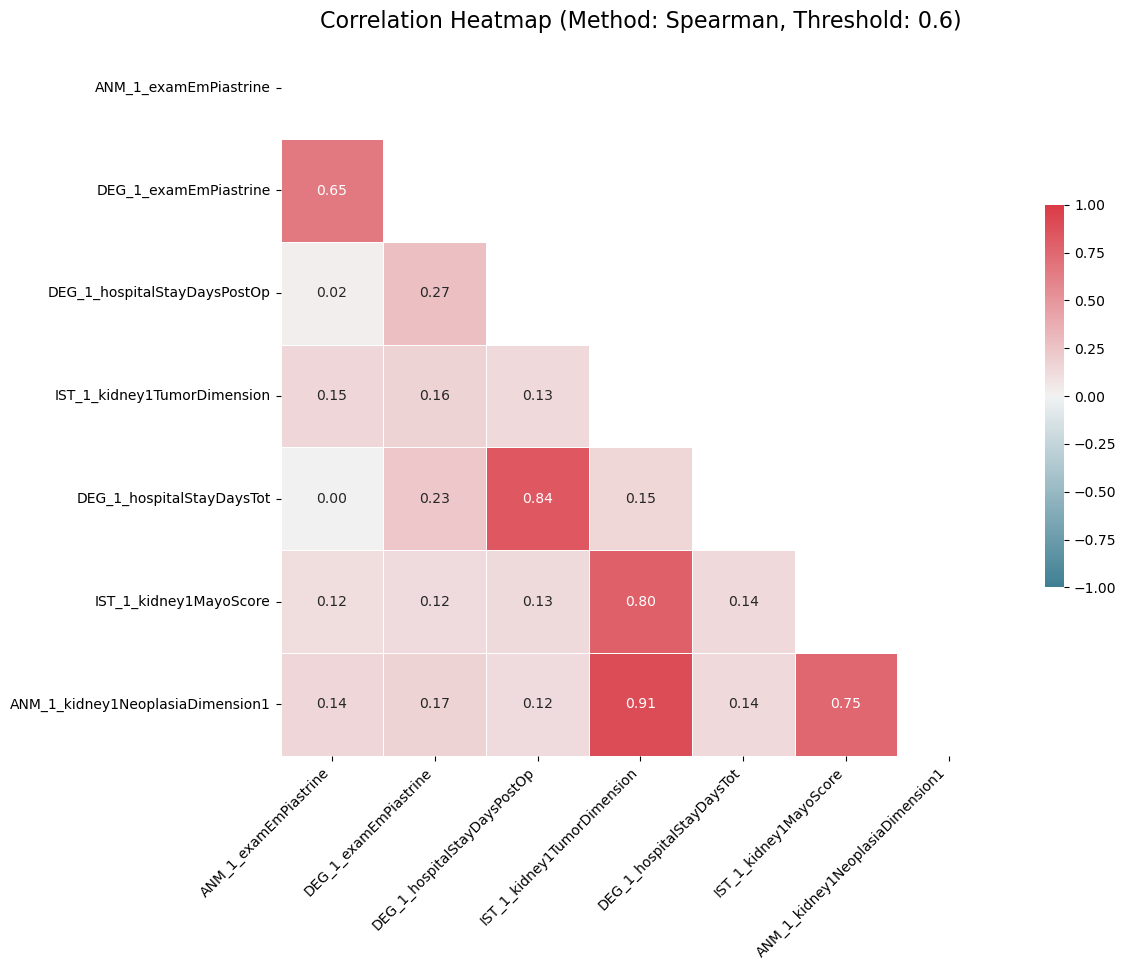

In [39]:
plot_correlation_heatmap(df=df_ohe[features_top_t1], method="spearman", threshold=0.6)

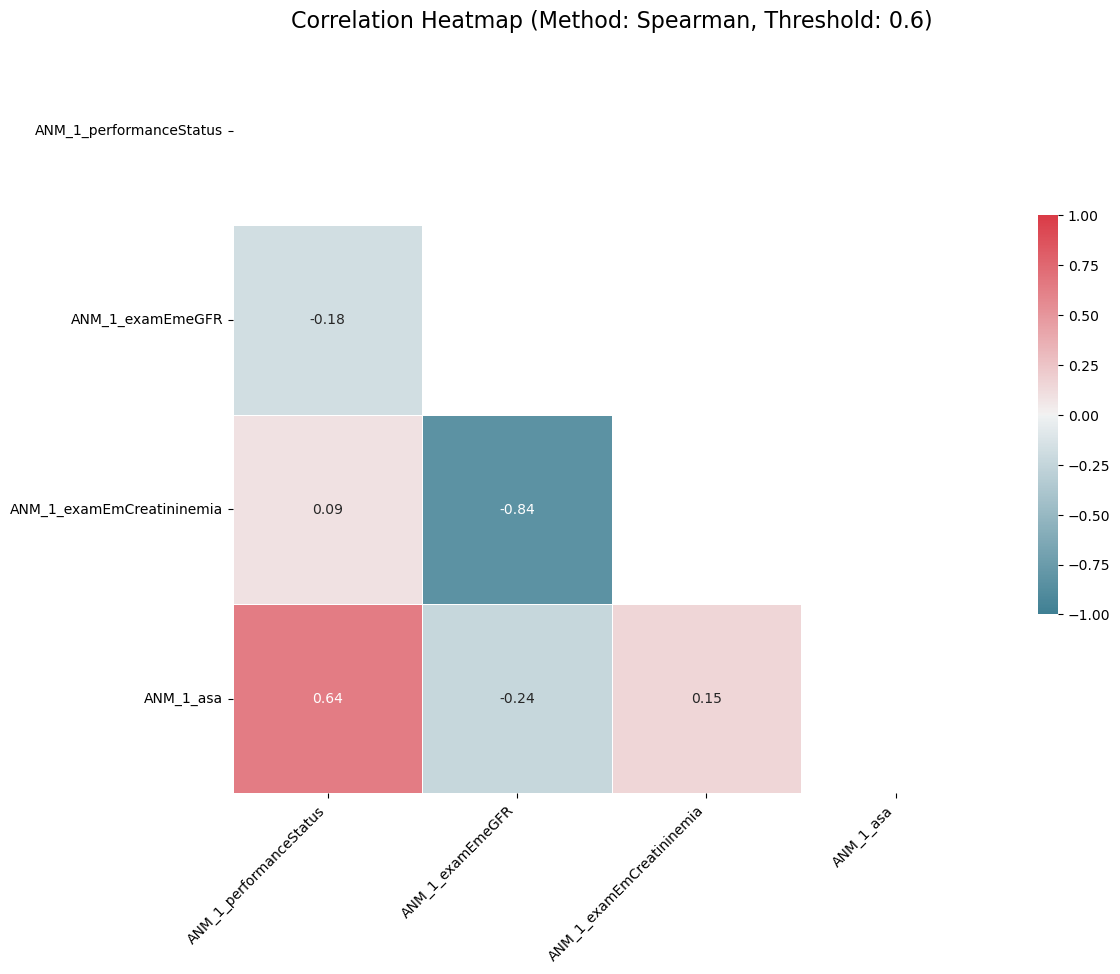

In [40]:
plot_correlation_heatmap(df=df_ohe[features_top_t0], method="spearman", threshold=0.6)

## Select by collinearity

Compared to the "standard" select_by_collinearity, if one of the features in a correlated pair is not present dataset external, then keep the other.

In [41]:
features_top_t1_corr = CollinearitySelector(df=df_ohe,
                               features_internal=features_top_t1,
                               features_external=features_top_t1_external,
                               method='spearman',
                               threshold=0.6,
                               top_x=10).select_features()

features_top_t0_corr = CollinearitySelector(df=df_ohe,
                               features_internal=features_top_t0,
                               features_external=features_top_t0_external,
                               method='spearman',
                               threshold=0.6,
                               top_x=8).select_features()
print(len(features_top_t1_corr))
print(len(features_top_t0_corr))

10
8


In [42]:
print(set(features_top_t1) - set(features_top_t1_corr))
print(set(features_top_t0) - set(features_top_t0_corr))
print()
assert(len(set(features_top_t1_corr) - set(features_top_t1_external)) == 0)
assert(len(set(features_top_t0_corr) - set(features_top_t0_external)) == 0)

{'ANM_1_kidney1NeoplasiaDimension1', 'DEG_1_examEmPiastrine', 'DEG_1_hospitalStayDaysTot', 'IST_1_kidney1MayoScore'}
{'ANM_1_asa', 'ANM_1_examEmCreatininemia'}



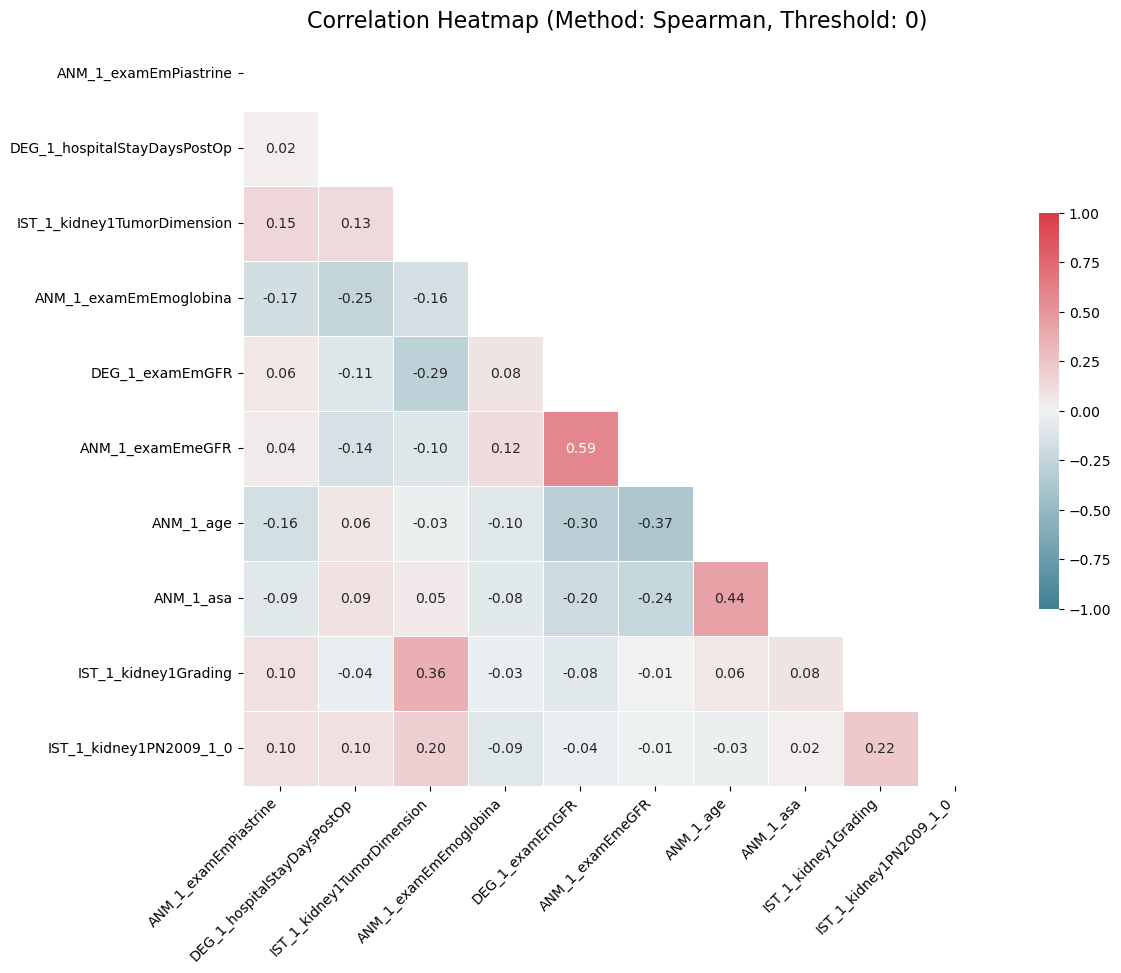

In [43]:
plot_correlation_heatmap(df=df_ohe[features_top_t1_corr], method="spearman", threshold=0)

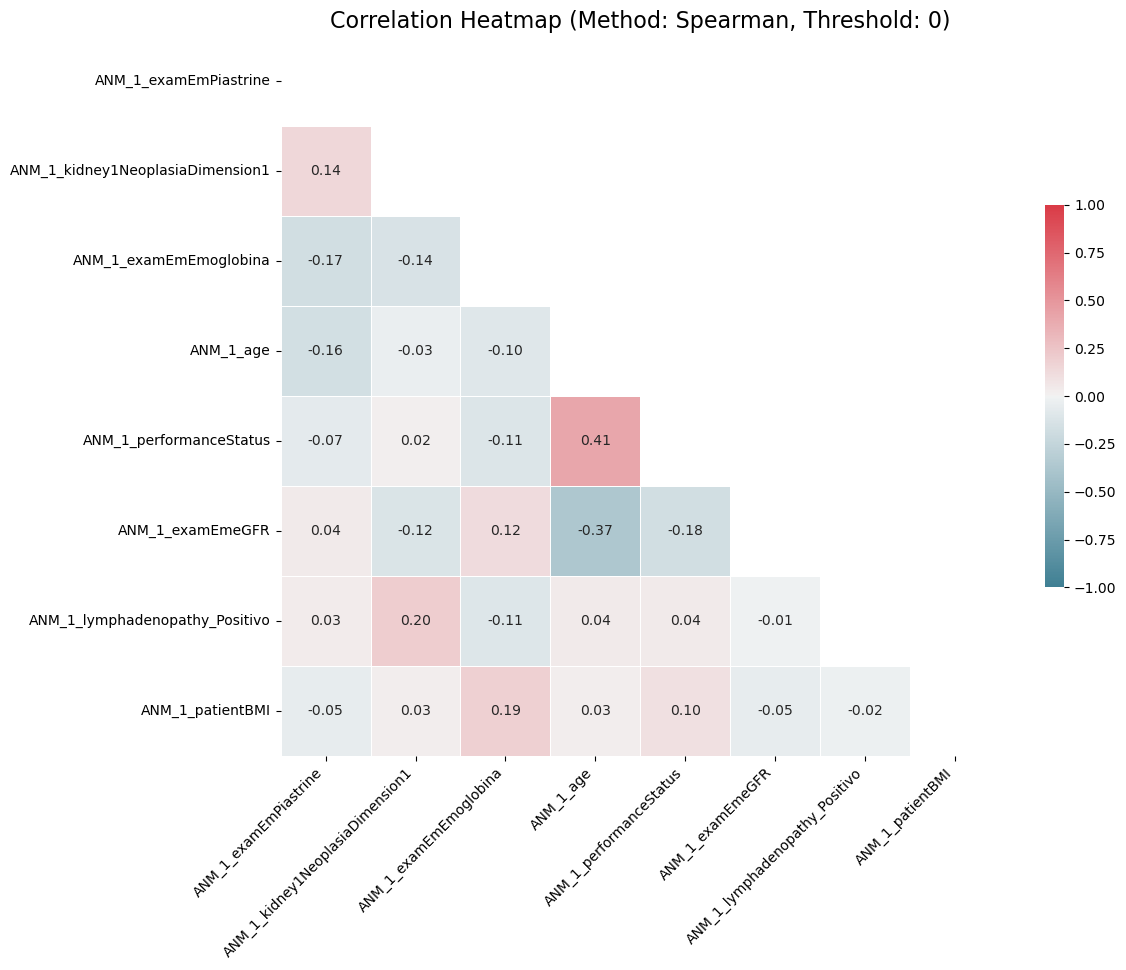

In [44]:
plot_correlation_heatmap(df=df_ohe[features_top_t0_corr], method="spearman", threshold=0)

In [45]:
del features_top_t1, features_top_t0

# T1 model `ComponentwiseGradientBoostingSurvivalAnalysis_T1_DBURI`

In [46]:
model_name = "ComponentwiseGradientBoostingSurvivalAnalysis_T1_DBURI"
mlflow.start_run(run_name=model_name, nested=True)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("n_features_top_t1_unfiltered", None)
mlflow.log_param("n_features_top_t1_collinearity_limited", len(features_top_t1_corr))

10

In [47]:
# Train the model
model_instance = ComponentwiseGradientBoostingSurvivalAnalysis(random_state=RANDOM_STATE)
param_grid = {
        "n_estimators": [200, 500],
        "subsample": [0.75, 1.0]
}
best_model, best_score = tune_sksurv_model_fixed_k(model=model_instance,
    param_grid=param_grid,
    X_tune=X[features_top_t1_corr],
    y_tune=y,
    random_state=RANDOM_STATE,
    n_folds=10)
# Log best performance obtained during tuning
mlflow.log_param("best_performance", -best_score)
# Log artifact
os.makedirs(DIR_MODEL_PKL, exist_ok=True)
model_path = os.path.join(DIR_MODEL_PKL, 'raw_{}_{}.pkl'.format(model_name, RANDOM_STATE))
joblib.dump(best_model, model_path)
mlflow.log_artifact(model_path)
# Log the selected features
selected_features_t1 = list(best_model.feature_names_in_)
mlflow.log_param("n_features_in", len(selected_features_t1))
# Create a dictionary for the JSON object
features_info = {
    "model": model_name,
    "timepoint": "T1",
    "feature_names_in": selected_features_t1
}
# Convert the dictionary to a JSON string
features_json_str = json.dumps(features_info, indent=2)
# Log the features as an artifact with a specific filename
with tempfile.TemporaryDirectory() as tmp_dir:
    # Define the full path with the desired filename
    file_path = os.path.join(tmp_dir, 'feature_names_in.json')
    # Write the JSON string to the file
    with open(file_path, 'w') as f:
        f.write(features_json_str)
    # Log the file as an artifact
    mlflow.log_artifact(file_path)
# Log best model hyperparameters
params_dict = dict(best_model.get_params())
params_arr = [(key, str(value)) for key, value in params_dict.items() if key!="random_state"]
mlflow.log_params(dict(params_arr))

In [48]:
mlflow.end_run()

### Check if all the features are available in external dataset

In [49]:
# Empty list if all the features are available in external dataset
print(len(selected_features_t1))
print(selected_features_t1)
print([x for x in selected_features_t1 if x not in col_external])

10
['ANM_1_examEmPiastrine', 'DEG_1_hospitalStayDaysPostOp', 'IST_1_kidney1TumorDimension', 'ANM_1_examEmEmoglobina', 'DEG_1_examEmGFR', 'ANM_1_examEmeGFR', 'ANM_1_age', 'ANM_1_asa', 'IST_1_kidney1Grading', 'IST_1_kidney1PN2009_1_0']
[]


# T0 model with all internal features `ExtraSurvivalTrees_T0_DBURI`

In [50]:
model_name = "ExtraSurvivalTrees_T0_DBURI"
mlflow.start_run(run_name=model_name, nested=True)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("n_features_top_t0_unfiltered", None)
mlflow.log_param("n_features_top_t0_collinearity_limited", len(features_top_t0_corr))

8

In [51]:
# Train the model
model_instance = ExtraSurvivalTrees(random_state=RANDOM_STATE)
param_grid = {
        "n_estimators": [50, 100, 200],
        "min_samples_split": [4, 10, 20],
        "min_samples_leaf": [2, 5, 10]
}
best_model, best_score = tune_sksurv_model_fixed_k(model=model_instance,
    param_grid=param_grid,
    X_tune=X[features_top_t0_corr],
    y_tune=y,
    random_state=RANDOM_STATE,
    n_folds=10)
# Log best performance obtained during tuning
mlflow.log_param("best_performance", -best_score)
# Log artifact
os.makedirs(DIR_MODEL_PKL, exist_ok=True)
model_path = os.path.join(DIR_MODEL_PKL, 'raw_{}_{}.pkl'.format(model_name, RANDOM_STATE))
joblib.dump(best_model, model_path)
mlflow.log_artifact(model_path)
# Log the selected features
selected_features_t0 = list(best_model.feature_names_in_)
mlflow.log_param("n_features_in", len(selected_features_t0))
# Create a dictionary for the JSON object
features_info = {
    "model": model_name,
    "timepoint": "T0",
    "feature_names_in": selected_features_t0
}
# Convert the dictionary to a JSON string
features_json_str = json.dumps(features_info, indent=2)
# Log the features as an artifact with a specific filename
with tempfile.TemporaryDirectory() as tmp_dir:
    # Define the full path with the desired filename
    file_path = os.path.join(tmp_dir, 'feature_names_in.json')
    # Write the JSON string to the file
    with open(file_path, 'w') as f:
        f.write(features_json_str)
    # Log the file as an artifact
    mlflow.log_artifact(file_path)
# Log best model hyperparameters
params_dict = dict(best_model.get_params())
params_arr = [(key, str(value)) for key, value in params_dict.items() if key!="random_state"]
mlflow.log_params(dict(params_arr))

In [52]:
mlflow.end_run()

### Check if all the features are available in external dataset

In [53]:
# Empty list if all the features are available in external dataset
print(len(selected_features_t0))
print(selected_features_t0)
print([x for x in selected_features_t0 if x not in col_external])

8
['ANM_1_examEmPiastrine', 'ANM_1_kidney1NeoplasiaDimension1', 'ANM_1_examEmEmoglobina', 'ANM_1_age', 'ANM_1_performanceStatus', 'ANM_1_examEmeGFR', 'ANM_1_lymphadenopathy_Positivo', 'ANM_1_patientBMI']
[]


# End mlflow run

In [54]:
mlflow.end_run()